In [ ]:
from google.colab import drive

drive.mount('/content/drive')


# **Veri Ön İşleme ve Hazırlık Süreci**

In [ ]:
import pandas as pd
path = "/content/drive/MyDrive/Staj Task_blueitfuture/water_potability/Watera.csv"
df = pd.read_csv(path)

df.shape, df.head()

((100000, 10),
      ph  hardness     tds  chlorine  sulfate  conductivity  organic_carbon  \
 0  7.14    440.98  614.26      2.12   208.39        350.92            7.22   
 1  6.41    242.82  387.89      3.93   313.10        153.36            9.92   
 2  6.29    133.09  225.55      1.46   332.04       1420.43            8.76   
 3  7.39     71.89  459.23      0.56   609.63      24142.89            9.62   
 4  6.31    273.01  308.99      0.64    52.59        196.85            1.05   
 
    trihalomethanes  turbidity  potability  
 0            17.32       2.23           0  
 1            20.69       2.07           0  
 2            32.87       5.05           0  
 3            42.80       2.26           0  
 4           133.38       5.30           0  )

In [ ]:
import numpy as np
import pandas as pd

print("SHAPE:", df.shape)
print("\nDTYPES:\n", df.dtypes)

mem_mb = df.memory_usage(deep=True).sum() / 1024**2
print(f"\nMemory usage: {mem_mb:.2f} MB")

dup = df.duplicated().sum()
print("\nDuplicates:", dup)

na = df.isna().sum().sort_values(ascending=False)
na_pct = (na / len(df) * 100).round(2)
missing_report = pd.DataFrame({"missing_count": na, "missing_%": na_pct})
print("\nTop missing columns:\n", missing_report.head(15))

num_cols = df.select_dtypes(include=np.number).columns.tolist()
cat_cols = df.select_dtypes(exclude=np.number).columns.tolist()
print("\nNumeric cols:", len(num_cols), num_cols[:10])
print("Non-numeric cols:", len(cat_cols), cat_cols[:10])

possible_targets = [c for c in df.columns if c.lower() in ["potability","target","label","y"]]
print("\nPossible target columns:", possible_targets)

if "Potability" in df.columns:
    vc = df["Potability"].value_counts(dropna=False)
    print("\nPotability distribution:\n", vc)
    print("\nPotability %:\n", (vc/len(df)*100).round(2))


SHAPE: (100000, 10)

DTYPES:
 ph                 float64
hardness           float64
tds                float64
chlorine           float64
sulfate            float64
conductivity       float64
organic_carbon     float64
trihalomethanes    float64
turbidity          float64
potability           int64
dtype: object

Memory usage: 7.63 MB

Duplicates: 0

Top missing columns:
                  missing_count  missing_%
ph                        3121       3.12
tds                       2384       2.38
conductivity              1598       1.60
sulfate                    813       0.81
hardness                     0       0.00
chlorine                     0       0.00
organic_carbon               0       0.00
trihalomethanes              0       0.00
turbidity                    0       0.00
potability                   0       0.00

Numeric cols: 10 ['ph', 'hardness', 'tds', 'chlorine', 'sulfate', 'conductivity', 'organic_carbon', 'trihalomethanes', 'turbidity', 'potability']
Non-numeric cols

In [ ]:
import pandas as pd
import numpy as np

TARGET = "potability"

print("\n=== Target distribution ===")
vc = df[TARGET].value_counts(dropna=False)
print(vc)
print("\nTarget %:")
print((vc / len(df) * 100).round(2))

print("\n=== Zero counts / % per column ===")
zero_stats = pd.DataFrame({
    "zero_count": (df == 0).sum(),
    "zero_%": ((df == 0).mean() * 100).round(2)
}).sort_values("zero_%", ascending=False)
print(zero_stats)

print("\n=== Describe with percentiles ===")
desc = df.describe(percentiles=[.01, .05, .25, .5, .75, .95, .99]).T
print(desc)

print("\n=== IQR outlier % per feature ===")
features = [c for c in df.columns if c != TARGET]
out_rows = []
for c in features:
    s = df[c].dropna()
    q1, q3 = s.quantile(0.25), s.quantile(0.75)
    iqr = q3 - q1
    lo, hi = q1 - 1.5 * iqr, q3 + 1.5 * iqr
    out_pct = ((s < lo) | (s > hi)).mean() * 100
    out_rows.append((c, float(lo), float(hi), round(out_pct, 2)))

out_df = pd.DataFrame(out_rows, columns=["col", "iqr_low", "iqr_high", "outlier_%"]).sort_values("outlier_%", ascending=False)
print(out_df)

print("\n=== Missing % by target class ===")
miss_by_target = df.groupby(TARGET).apply(lambda g: g.isna().mean() * 100).round(2)
print(miss_by_target)

print("\n=== Zero % by target class (top 10 columns) ===")
zero_by_target = df.groupby(TARGET).apply(lambda g: (g == 0).mean() * 100).round(2)
top_cols = zero_stats.head(10).index.tolist()
print(zero_by_target[top_cols])

print("\n=== Correlation with target ===")
corr = df.corr(numeric_only=True)[TARGET].sort_values(ascending=False)
print(corr)

print("\n=== Sanity checks ===")
print("Any inf?", np.isinf(df.select_dtypes(include=[np.number])).any().any())
print("Negative counts per col:")
neg_counts = (df[features] < 0).sum().sort_values(ascending=False)
print(neg_counts[neg_counts > 0] if (neg_counts > 0).any() else "No negatives found.")



=== Target distribution ===
potability
0    92384
1     7616
Name: count, dtype: int64

Target %:
potability
0    92.38
1     7.62
Name: count, dtype: float64

=== Zero counts / % per column ===
                 zero_count  zero_%
potability            92384   92.38
chlorine                175    0.18
turbidity                99    0.10
organic_carbon           36    0.04
trihalomethanes          10    0.01
ph                        0    0.00
hardness                  1    0.00
conductivity              0    0.00
tds                       0    0.00
sulfate                   1    0.00

=== Describe with percentiles ===
                    count         mean          std   min       1%        5%  \
ph                96879.0     7.249512     0.995618  5.00   5.1200    5.6300   
hardness         100000.0   309.214750   222.321384  0.00  24.7899   54.7095   
tds               97616.0   330.220307   246.036043  0.03  30.3600   73.1900   
chlorine         100000.0     2.500058     1.616047  

/tmp/ipython-input-2911101607.py:43: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  miss_by_target = df.groupby(TARGET).apply(lambda g: g.isna().mean() * 100).round(2)
/tmp/ipython-input-2911101607.py:48: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  zero_by_target = df.groupby(TARGET).apply(lambda g: (g == 0).mean() * 100).round(2)


In [ ]:
import numpy as np
import pandas as pd

TARGET = "potability"
df0 = df.copy()

print("SHAPE:", df0.shape)

print("\nMissing %:")
print((df0.isna().mean() * 100).round(2).sort_values(ascending=False))

print("\nZero % (features only):")
features = [c for c in df0.columns if c != TARGET]
zero_pct = ((df0[features] == 0).mean() * 100).round(3).sort_values(ascending=False)
print(zero_pct)

print("\nPercentiles (1%, 5%, 50%, 95%, 99%) for features:")
desc = df0[features].describe(percentiles=[.01, .05, .5, .95, .99]).T[
    ["min", "1%", "5%", "50%", "95%", "99%", "max"]
]
print(desc)

tail_score = (desc["99%"] / (desc["95%"] + 1e-9)).sort_values(ascending=False)
print("\nTail score = (99% / 95%); larger values indicate a longer/heavier tail:")
print(tail_score)

suspect_cols = tail_score[tail_score > 3].index.tolist()
print("\nSuspected columns (tail_score > 3):", suspect_cols)


df_prep = df0.copy()

for c in features:
    if df_prep[c].isna().any():
        df_prep[c + "_missing"] = df_prep[c].isna().astype(int)

medians = df_prep[features].median(numeric_only=True)
df_prep[features] = df_prep[features].fillna(medians)

print("\nAfter imputation:")
print("Missing remaining:", df_prep[features].isna().sum().sum())


OUTLIER_STRATEGY = "cap99"

df_ready = df_prep.copy()

if OUTLIER_STRATEGY == "cap99":
    caps = df_ready[features].quantile(0.99)
    for c in suspect_cols:
        df_ready[c] = np.minimum(df_ready[c], caps[c])
    print("\nOutlier strategy: cap at 99% for columns:", suspect_cols)

elif OUTLIER_STRATEGY == "log1p":
    for c in suspect_cols:
        df_ready[c] = np.log1p(df_ready[c])
    print("\nOutlier strategy: log1p for columns:", suspect_cols)

else:
    print("\nNo outlier handling (left as-is).")

print("\ndf_ready shape:", df_ready.shape)
print("Any NaN left in features?", df_ready[features].isna().any().any())
print("Any inf?", np.isinf(df_ready.select_dtypes(include=[np.number])).any().any())

print("\nQuick summary after preparation (same percentiles):")
desc2 = df_ready[features].describe(percentiles=[.01, .05, .5, .95, .99]).T[
    ["min", "1%", "5%", "50%", "95%", "99%", "max"]
]
print(desc2)


SHAPE: (100000, 10)

Missing %:
ph                 3.12
tds                2.38
conductivity       1.60
sulfate            0.81
hardness           0.00
chlorine           0.00
organic_carbon     0.00
trihalomethanes    0.00
turbidity          0.00
potability         0.00
dtype: float64

Zero % (features only):
chlorine           0.175
turbidity          0.099
organic_carbon     0.036
trihalomethanes    0.010
hardness           0.001
sulfate            0.001
ph                 0.000
tds                0.000
conductivity       0.000
dtype: float64

Percentiles (1%, 5%, 50%, 95%, 99%) for features:
                  min       1%        5%       50%        95%         99%  \
ph               5.00   5.1200    5.6300     7.240     8.9500      9.7800   
hardness         0.00  24.7899   54.7095   271.080   844.8005   1051.3001   
tds              0.03  30.3600   73.1900   270.155   925.3125   1063.6540   
chlorine         0.00   0.0500    0.2500     2.410     4.4905      8.0500   
sulfate     

In [ ]:
df_ready.to_csv("water_prep_ready.csv", index=False)


In [ ]:
import numpy as np
import pandas as pd

TARGET = "potability"
features = [c for c in df.columns if c != TARGET]

cap_99 = df_prep[features].quantile(0.99)["conductivity"]

n_capped = (df_prep["conductivity"] > cap_99).sum()
pct_capped = n_capped / len(df_prep) * 100

print("Conductivity cap (99%):", cap_99)
print("Rows capped:", n_capped, f"({pct_capped:.2f}%)")

df_ready.to_csv("water_ready_processed.csv", index=False)
print("Saved:", "water_ready_processed.csv")

print("\n=== Report-ready notes ===")
print(f"- Missing values were low (ph ~3.12%, tds ~2.38%, conductivity ~1.60%, sulfate ~0.81%) and imputed with median; missing indicators were added.")
print(f"- Zero values were rare in features (<=0.175%), so zeros were kept as valid values.")
print(f"- Conductivity showed a very heavy tail (99%/95% ≈ 10.26), so values were capped at the 99th percentile (capped rows ≈ {pct_capped:.2f}%).")


Conductivity cap (99%): 27992.1622999999
Rows capped: 1000 (1.00%)
Saved: water_ready_processed.csv

=== Report-ready notes ===
- Missing values were low (ph ~3.12%, tds ~2.38%, conductivity ~1.60%, sulfate ~0.81%) and imputed with median; missing indicators were added.
- Zero values were rare in features (<=0.175%), so zeros were kept as valid values.
- Conductivity showed a very heavy tail (99%/95% ≈ 10.26), so values were capped at the 99th percentile (capped rows ≈ 1.00%).


In [ ]:
from pathlib import Path

csv_path = Path("/content/drive/MyDrive/Staj Task_blueitfuture/water_potability/Watera.csv")
PROJECT_DIR = csv_path.parent

out_path = PROJECT_DIR / "data" / "processed" / "water_ready_processed.csv"
out_path.parent.mkdir(parents=True, exist_ok=True)

df_ready.to_csv(out_path, index=False)
print("Saved to:", out_path)


Saved to: /content/drive/MyDrive/Staj Task_blueitfuture/water_potability/data/processed/water_ready_processed.csv


In [ ]:
from pathlib import Path
import pandas as pd
import time

FILE_PATH = Path("/content/drive/MyDrive/Staj Task_blueitfuture/water_potability/Watera.csv")
BACKUP_PATH = FILE_PATH.with_name("Watera_RAW_BACKUP.csv")

print("df_ready shape:", df_ready.shape)
print("df_ready missing total:", df_ready.isna().sum().sum())
print("df_ready has *_missing cols?", any(c.endswith("_missing") for c in df_ready.columns))
print("df_ready conductivity max:", df_ready["conductivity"].max())

if not BACKUP_PATH.exists():
    FILE_PATH.replace(BACKUP_PATH)
    print("Backup created:", BACKUP_PATH)
else:
    print("Backup already exists:", BACKUP_PATH)

df_ready.to_csv(FILE_PATH, index=False)
print("Saved cleaned data to:", FILE_PATH)
print("Modified:", time.ctime(FILE_PATH.stat().st_mtime))
print("Size:", FILE_PATH.stat().st_size)

d = pd.read_csv(FILE_PATH)
print("\n=== AFTER overwrite check ===")
print("Shape:", d.shape)
print("Missing total:", d.isna().sum().sum())
print("Has *_missing cols?", any(c.endswith("_missing") for c in d.columns))
print("Conductivity max:", d["conductivity"].max())
print("Indicator cols:", [c for c in d.columns if c.endswith("_missing")])


df_ready shape: (100000, 14)
df_ready missing total: 0
df_ready has *_missing cols? True
df_ready conductivity max: 27992.1622999999
Backup created: /content/drive/MyDrive/Staj Task_blueitfuture/water_potability/Watera_RAW_BACKUP.csv
Saved cleaned data to: /content/drive/MyDrive/Staj Task_blueitfuture/water_potability/Watera.csv
Modified: Wed Dec 31 12:08:35 2025
Size: 6396948

=== AFTER overwrite check ===
Shape: (100000, 14)
Missing total: 0
Has *_missing cols? True
Conductivity max: 27992.1622999999
Indicator cols: ['ph_missing', 'tds_missing', 'sulfate_missing', 'conductivity_missing']


# Verilerin eğitim, doğrulama ve test kümelerine ayrılması.


In [ ]:
from pathlib import Path
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split


TARGET = "potability"
RANDOM_STATE = 42
TRAIN_RATIO = 0.70
VAL_RATIO = 0.15
TEST_RATIO = 0.15
assert abs(TRAIN_RATIO + VAL_RATIO + TEST_RATIO - 1.0) < 1e-9

BASE_DIR = Path("/content/drive/MyDrive/Staj Task_blueitfuture/water_potability")
RAW_PATH = BASE_DIR / "Watera_RAW_BACKUP.csv"
SPLITS_DIR = BASE_DIR / "data" / "splits"
PROCESSED_DIR = BASE_DIR / "data" / "processed"
SPLITS_DIR.mkdir(parents=True, exist_ok=True)
PROCESSED_DIR.mkdir(parents=True, exist_ok=True)


df_raw = pd.read_csv(RAW_PATH)
assert TARGET in df_raw.columns

features = [c for c in df_raw.columns if c != TARGET]
X = df_raw[features].copy()
y = df_raw[TARGET].astype(int).copy()

X_train, X_temp, y_train, y_temp = train_test_split(
    X, y,
    test_size=(1 - TRAIN_RATIO),
    random_state=RANDOM_STATE,
    stratify=y
)

test_size_in_temp = TEST_RATIO / (VAL_RATIO + TEST_RATIO)
X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp,
    test_size=test_size_in_temp,
    random_state=RANDOM_STATE,
    stratify=y_temp
)

def dist(name, y_part):
    vc = y_part.value_counts()
    pct = (y_part.value_counts(normalize=True) * 100).round(2)
    return f"{name}: n={len(y_part)} | counts={vc.to_dict()} | pct={pct.to_dict()}"

print(dist("TRAIN", y_train))
print(dist("VAL", y_val))
print(dist("TEST", y_test))

pd.concat([X_train.reset_index(drop=True), y_train.reset_index(drop=True)], axis=1)\
  .to_csv(SPLITS_DIR / "water_train.csv", index=False)
pd.concat([X_val.reset_index(drop=True), y_val.reset_index(drop=True)], axis=1)\
  .to_csv(SPLITS_DIR / "water_val.csv", index=False)
pd.concat([X_test.reset_index(drop=True), y_test.reset_index(drop=True)], axis=1)\
  .to_csv(SPLITS_DIR / "water_test.csv", index=False)


summary_lines = []
summary_lines.append("=== Split distributions ===")
summary_lines.append(dist("TRAIN", y_train))
summary_lines.append(dist("VAL", y_val))
summary_lines.append(dist("TEST", y_test))

train_missing_cols = [c for c in features if X_train[c].isna().any()]
summary_lines.append("\n=== Missing columns in TRAIN (indicator created) ===")
summary_lines.append(str(train_missing_cols))

def add_missing_indicators(X_df, cols):
    X_out = X_df.copy()
    for c in cols:
        X_out[c + "_missing"] = X_out[c].isna().astype(int)
    return X_out

X_train_p = add_missing_indicators(X_train, train_missing_cols)
X_val_p   = add_missing_indicators(X_val, train_missing_cols)
X_test_p  = add_missing_indicators(X_test, train_missing_cols)

medians = X_train_p[features].median(numeric_only=True)
summary_lines.append("\n=== Medians computed from TRAIN ===")
summary_lines.append(medians.to_string())

def median_impute(X_df, med):
    X_out = X_df.copy()
    X_out[features] = X_out[features].fillna(med)
    return X_out

X_train_p = median_impute(X_train_p, medians)
X_val_p   = median_impute(X_val_p, medians)
X_test_p  = median_impute(X_test_p, medians)

if "conductivity" in features:
    cap99 = X_train_p["conductivity"].quantile(0.99)
    n_capped_train = (X_train_p["conductivity"] > cap99).sum()
    summary_lines.append("\n=== Conductivity cap (computed from TRAIN) ===")
    summary_lines.append(f"cap99={cap99}")
    summary_lines.append(f"rows capped in TRAIN={n_capped_train} ({n_capped_train/len(X_train_p)*100:.2f}%)")

    for X_part in [X_train_p, X_val_p, X_test_p]:
        X_part["conductivity"] = np.minimum(X_part["conductivity"], cap99)


train_proc = pd.concat([X_train_p.reset_index(drop=True), y_train.reset_index(drop=True)], axis=1)
val_proc   = pd.concat([X_val_p.reset_index(drop=True),   y_val.reset_index(drop=True)], axis=1)
test_proc  = pd.concat([X_test_p.reset_index(drop=True),  y_test.reset_index(drop=True)], axis=1)

train_proc.to_csv(PROCESSED_DIR / "water_train_processed.csv", index=False)
val_proc.to_csv(PROCESSED_DIR / "water_val_processed.csv", index=False)
test_proc.to_csv(PROCESSED_DIR / "water_test_processed.csv", index=False)

summary_lines.append("\n=== Sanity checks (processed) ===")
summary_lines.append(f"train shape={train_proc.shape} missing_total={train_proc.isna().sum().sum()}")
summary_lines.append(f"val   shape={val_proc.shape} missing_total={val_proc.isna().sum().sum()}")
summary_lines.append(f"test  shape={test_proc.shape} missing_total={test_proc.isna().sum().sum()}")



print("\nSaved RAW splits to:", SPLITS_DIR)
print("Saved PROCESSED splits to:", PROCESSED_DIR)


# **Belirlenen modeller üzerinde eğitim aşaması**


## **1) Random Forest**


In [ ]:
from pathlib import Path
import pandas as pd
import numpy as np
import time

from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    confusion_matrix, average_precision_score
)

BASE_DIR = Path("/content/drive/MyDrive/Staj Task_blueitfuture/water_potability")
TRAIN_PATH = BASE_DIR / "data" / "processed" / "water_train_processed.csv"
VAL_PATH   = BASE_DIR / "data" / "processed" / "water_val_processed.csv"

TARGET = "potability"

train_df = pd.read_csv(TRAIN_PATH)
val_df   = pd.read_csv(VAL_PATH)

X_train = train_df.drop(columns=[TARGET])
y_train = train_df[TARGET].astype(int)

X_val = val_df.drop(columns=[TARGET])
y_val = val_df[TARGET].astype(int)

print("Train shape:", X_train.shape, "| Val shape:", X_val.shape)

def eval_on_val(model, Xv, yv, threshold=0.5):
    proba = model.predict_proba(Xv)[:, 1]
    pred = (proba >= threshold).astype(int)

    acc  = accuracy_score(yv, pred)
    prec = precision_score(yv, pred, pos_label=1, zero_division=0)
    rec  = recall_score(yv, pred, pos_label=1, zero_division=0)
    f1   = f1_score(yv, pred, pos_label=1, zero_division=0)

    tn, fp, fn, tp = confusion_matrix(yv, pred).ravel()
    pr_auc = average_precision_score(yv, proba)

    return {
        "accuracy": acc,
        "precision_1": prec,
        "recall_1": rec,
        "f1_1": f1,
        "pr_auc": pr_auc,
        "tn": int(tn), "fp": int(fp), "fn": int(fn), "tp": int(tp),
        "threshold": threshold
    }

def pretty_print(name, m):
    print(f"\n{name} (Validation Set)")
    print(f"  - Accuracy: {m['accuracy']:.4f}")
    print(f"  - Precision (class=1): {m['precision_1']:.4f}")
    print(f"  - Recall (class=1): {m['recall_1']:.4f}")
    print(f"  - F1-Score (class=1): {m['f1_1']:.4f}")

candidates = [
    {
        "name": "RF_C (more regularization)",
        "params": dict(
            n_estimators=700,
            random_state=42,
            n_jobs=-1,
            class_weight="balanced_subsample",
            max_depth=15,
            min_samples_leaf=5
        )
    },
]

results = []
best = None
best_key = -1.0

for c in candidates:
    rf = RandomForestClassifier(**c["params"])

    t0 = time.time()
    rf.fit(X_train, y_train)
    fit_time = time.time() - t0

    metrics = eval_on_val(rf, X_val, y_val, threshold=0.5)
    metrics["model_name"] = c["name"]
    metrics["fit_time_sec"] = round(fit_time, 2)
    results.append(metrics)

    pretty_print(c["name"], metrics)
    print(f"  Train time (sec): {fit_time:.2f}")

    if metrics["f1_1"] > best_key:
        best_key = metrics["f1_1"]
        best = (rf, metrics)

print("\n" + "="*60)
print("BEST MODEL ON VALIDATION (by F1 class=1):")
pretty_print(best[1]["model_name"], best[1])
print("Fit time (sec):", best[1]["fit_time_sec"])
print("="*60)

tbl = pd.DataFrame(results)[
    ["model_name","accuracy","precision_1","recall_1","f1_1","pr_auc","tn","fp","fn","tp","fit_time_sec"]
].sort_values("f1_1", ascending=False)

print("\n=== Comparison Table (VAL) ===")
print(tbl.to_string(index=False))


Train shape: (69999, 13) | Val shape: (15000, 13)

RF_C (more regularization) (Validation Set)
  - Accuracy: 0.9973
  - Precision (class=1): 0.9669
  - Recall (class=1): 0.9982
  - F1-Score (class=1): 0.9823
  Train time (sec): 72.72

BEST MODEL ON VALIDATION (by F1 class=1):

RF_C (more regularization) (Validation Set)
  - Accuracy: 0.9973
  - Precision (class=1): 0.9669
  - Recall (class=1): 0.9982
  - F1-Score (class=1): 0.9823
Fit time (sec): 72.72

=== Comparison Table (VAL) ===
                model_name  accuracy  precision_1  recall_1     f1_1   pr_auc    tn  fp  fn   tp  fit_time_sec
RF_C (more regularization)  0.997267     0.966921  0.998249 0.982335 0.998287 13819  39   2 1140         72.72


# **Logistic Regression**

In [ ]:
from pathlib import Path
import pandas as pd
import time

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix

BASE_DIR = Path("/content/drive/MyDrive/Staj Task_blueitfuture/water_potability")
TRAIN_PATH = BASE_DIR / "data" / "processed" / "water_train_processed.csv"
VAL_PATH   = BASE_DIR / "data" / "processed" / "water_val_processed.csv"

TARGET = "potability"

train_df = pd.read_csv(TRAIN_PATH)
val_df   = pd.read_csv(VAL_PATH)

X_train = train_df.drop(columns=[TARGET])
y_train = train_df[TARGET].astype(int)

X_val = val_df.drop(columns=[TARGET])
y_val = val_df[TARGET].astype(int)

print("Train shape:", X_train.shape, "| Val shape:", X_val.shape)

lr_model = Pipeline(steps=[
    ("scaler", StandardScaler()),
    ("lr", LogisticRegression(
        max_iter=3000,
        class_weight="balanced",
        solver="lbfgs"
    ))
])

t0 = time.time()
lr_model.fit(X_train, y_train)
train_time = time.time() - t0

y_pred = lr_model.predict(X_val)

acc = accuracy_score(y_val, y_pred)
prec = precision_score(y_val, y_pred, pos_label=1, zero_division=0)
rec = recall_score(y_val, y_pred, pos_label=1, zero_division=0)
f1 = f1_score(y_val, y_pred, pos_label=1, zero_division=0)


print("\nLogistic Regression (Validation Set)")
print(f"  - Accuracy: {acc:.4f}")
print(f"  - Precision (class=1): {prec:.4f}")
print(f"  - Recall (class=1): {rec:.4f}")
print(f"  - F1-Score (class=1): {f1:.4f}")


Train shape: (69999, 13) | Val shape: (15000, 13)

Logistic Regression (Validation Set)
  - Accuracy: 0.7807
  - Precision (class=1): 0.2364
  - Recall (class=1): 0.8433
  - F1-Score (class=1): 0.3692


# XGBoost

In [ ]:
from pathlib import Path
import pandas as pd
import time

from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    confusion_matrix, average_precision_score
)

import xgboost as xgb


BASE_DIR = Path("/content/drive/MyDrive/Staj Task_blueitfuture/water_potability")
TRAIN_PATH = BASE_DIR / "data" / "processed" / "water_train_processed.csv"
VAL_PATH   = BASE_DIR / "data" / "processed" / "water_val_processed.csv"
TARGET = "potability"

train_df = pd.read_csv(TRAIN_PATH)
val_df   = pd.read_csv(VAL_PATH)

X_train = train_df.drop(columns=[TARGET])
y_train = train_df[TARGET].astype(int)

X_val = val_df.drop(columns=[TARGET])
y_val = val_df[TARGET].astype(int)

neg = int((y_train == 0).sum())
pos = int((y_train == 1).sum())
scale_pos_weight = neg / max(pos, 1)

model = xgb.XGBClassifier(
    n_estimators=3000,
    learning_rate=0.05,
    max_depth=6,
    subsample=0.8,
    colsample_bytree=0.8,
    reg_lambda=1.0,
    min_child_weight=1,
    gamma=0,
    objective="binary:logistic",
    eval_metric="aucpr",
    scale_pos_weight=scale_pos_weight,
    n_jobs=-1,
    random_state=42,

    early_stopping_rounds=50,

    verbosity=0
)

t0 = time.time()
model.fit(
    X_train, y_train,
    eval_set=[(X_val, y_val)],
    verbose=False
)
_ = time.time() - t0
proba = model.predict_proba(X_val)[:, 1]
threshold = 0.5
y_pred = (proba >= threshold).astype(int)

acc  = accuracy_score(y_val, y_pred)
prec = precision_score(y_val, y_pred, pos_label=1, zero_division=0)
rec  = recall_score(y_val, y_pred, pos_label=1, zero_division=0)
f1   = f1_score(y_val, y_pred, pos_label=1, zero_division=0)

print("XGBoost (Validation Set)")
print(f"  - Accuracy: {acc:.4f}")
print(f"  - Precision (class=1): {prec:.4f}")
print(f"  - Recall (class=1): {rec:.4f}")
print(f"  - F1-Score (class=1): {f1:.4f}")


XGBoost (Validation Set)
  - Accuracy: 0.9957
  - Precision (class=1): 0.9484
  - Recall (class=1): 0.9982
  - F1-Score (class=1): 0.9727


## **`LightGBM`**

In [ ]:
from pathlib import Path
import pandas as pd
import time

import lightgbm as lgb
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

BASE_DIR = Path("/content/drive/MyDrive/Staj Task_blueitfuture/water_potability")
TRAIN_PATH = BASE_DIR / "data" / "processed" / "water_train_processed.csv"
VAL_PATH   = BASE_DIR / "data" / "processed" / "water_val_processed.csv"
TARGET = "potability"

train_df = pd.read_csv(TRAIN_PATH)
val_df   = pd.read_csv(VAL_PATH)

X_train = train_df.drop(columns=[TARGET])
y_train = train_df[TARGET].astype(int)

X_val = val_df.drop(columns=[TARGET])
y_val = val_df[TARGET].astype(int)

neg = int((y_train == 0).sum())
pos = int((y_train == 1).sum())
scale_pos_weight = neg / max(pos, 1)

model = lgb.LGBMClassifier(
    n_estimators=5000,
    learning_rate=0.05,
    num_leaves=63,
    max_depth=-1,
    subsample=0.8,
    colsample_bytree=0.8,
    reg_lambda=1.0,
    min_child_samples=20,
    objective="binary",
    scale_pos_weight=scale_pos_weight,
    n_jobs=-1,
    random_state=42,
    verbose=-1
)

t0 = time.time()
model.fit(
    X_train, y_train,
    eval_set=[(X_val, y_val)],
    eval_metric="binary_logloss",
    callbacks=[lgb.early_stopping(stopping_rounds=50, verbose=False)]
)
train_time = time.time() - t0

proba = model.predict_proba(X_val)[:, 1]
y_pred = (proba >= 0.5).astype(int)

acc  = accuracy_score(y_val, y_pred)
prec = precision_score(y_val, y_pred, pos_label=1, zero_division=0)
rec  = recall_score(y_val, y_pred, pos_label=1, zero_division=0)
f1   = f1_score(y_val, y_pred, pos_label=1, zero_division=0)

print("LightGBM (Validation Set)")
print(f"  - Accuracy: {acc:.4f}")
print(f"  - Precision (class=1): {prec:.4f}")
print(f"  - Recall (class=1): {rec:.4f}")
print(f"  - F1-Score (class=1): {f1:.4f}")


LightGBM (Validation Set)
  - Accuracy: 0.9959
  - Precision (class=1): 0.9530
  - Recall (class=1): 0.9947
  - F1-Score (class=1): 0.9734


# **LightGBM With test_Dataset**


Train+Val shape: (84999, 13) | Test shape: (15001, 13)

Random Forest (RF_C) (TEST Set)
  - Accuracy: 0.9981
  - Precision (class=1): 0.9761
  - Recall (class=1): 0.9991
  - F1-Score (class=1): 0.9875
  - PR-AUC: 0.9987
  Confusion Matrix (counts):
    TN: 13830, FP: 28
    FN: 1, TP: 1142
  - Train time (sec): 93.11
  - Threshold: 0.5


/tmp/ipython-input-2788409489.py:117: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


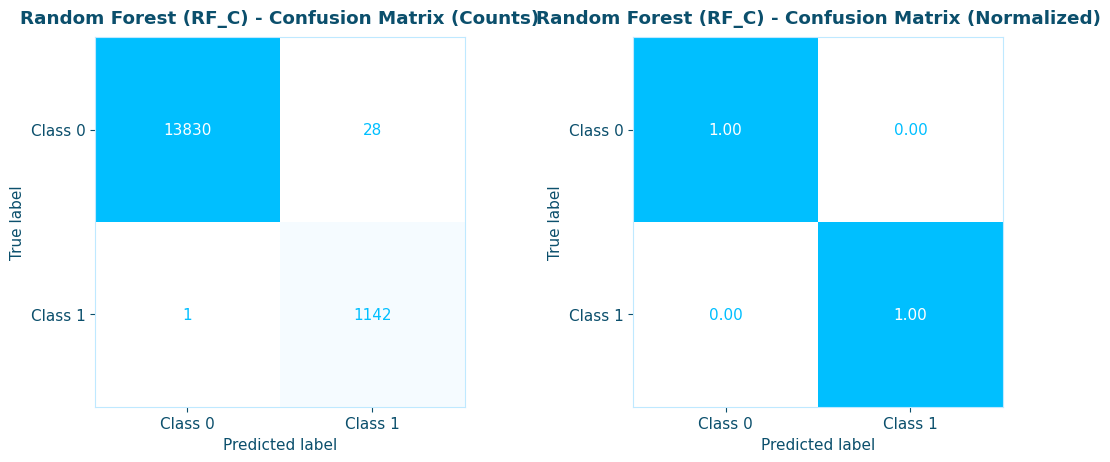

[LightGBM] [Info] Number of positive: 6473, number of negative: 78526
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.050390 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2303
[LightGBM] [Info] Number of data points in the train set: 84999, number of used features: 13
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.076154 -> initscore=-2.495790
[LightGBM] [Info] Start training from score -2.495790
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain

/tmp/ipython-input-2788409489.py:117: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


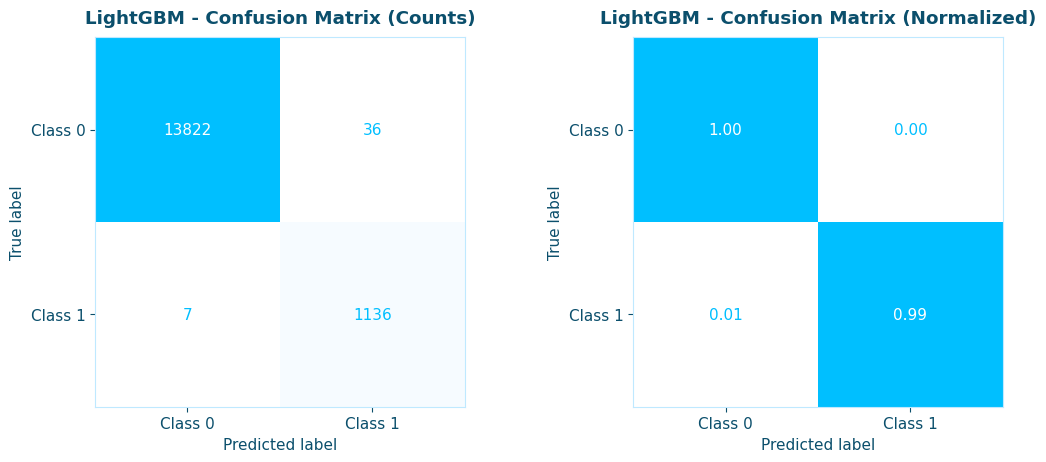


WINNER ON TEST (by F1 class=1): Random Forest (RF_C)


In [ ]:
from pathlib import Path
import pandas as pd
import numpy as np
import time

import lightgbm as lgb
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap

from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    confusion_matrix,
    average_precision_score,
    ConfusionMatrixDisplay,
)


plt.rcParams.update({
    "figure.facecolor": "white",
    "axes.facecolor": "white",
    "axes.edgecolor": "#BFE9FF",
    "axes.labelcolor": "#0B4F6C",
    "text.color": "#0B4F6C",
    "xtick.color": "#0B4F6C",
    "ytick.color": "#0B4F6C",
    "font.size": 11
})

SKYWHITE_CMAP = LinearSegmentedColormap.from_list(
    "skywhite",
    ["#FFFFFF", "#D9F2FF", "#87CEFA", "#00BFFF"]
)


BASE_DIR = Path("/content/drive/MyDrive/Staj Task_blueitfuture/water_potability")
TRAIN_PATH = BASE_DIR / "data" / "processed" / "water_train_processed.csv"
VAL_PATH   = BASE_DIR / "data" / "processed" / "water_val_processed.csv"
TEST_PATH  = BASE_DIR / "data" / "processed" / "water_test_processed.csv"

TARGET = "potability"

train_df = pd.read_csv(TRAIN_PATH)
val_df   = pd.read_csv(VAL_PATH)
test_df  = pd.read_csv(TEST_PATH)

X_train = train_df.drop(columns=[TARGET])
y_train = train_df[TARGET].astype(int)

X_val = val_df.drop(columns=[TARGET])
y_val = val_df[TARGET].astype(int)

X_test = test_df.drop(columns=[TARGET])
y_test = test_df[TARGET].astype(int)

X_tv = pd.concat([X_train, X_val], axis=0).reset_index(drop=True)
y_tv = pd.concat([y_train, y_val], axis=0).reset_index(drop=True)

print("Train+Val shape:", X_tv.shape, "| Test shape:", X_test.shape)


def plot_confusion_matrices(y_true, y_pred, title_prefix="Model"):
    """
    يعرض مصفوفتين جنب بعض:
    1) Counts
    2) Normalized by True labels
    بألوان أبيض + أزرق سماوي
    """
    cm_counts = confusion_matrix(y_true, y_pred, labels=[0, 1])
    cm_norm_true = confusion_matrix(y_true, y_pred, labels=[0, 1], normalize="true")

    fig, axes = plt.subplots(
        1, 2, figsize=(12.5, 4.8),
        facecolor="white",
        gridspec_kw={"wspace": 0.25}
    )

    disp_counts = ConfusionMatrixDisplay(
        confusion_matrix=cm_counts,
        display_labels=["Class 0", "Class 1"]
    )
    disp_counts.plot(
        ax=axes[0],
        values_format="d",
        cmap=SKYWHITE_CMAP,
        colorbar=False
    )
    axes[0].set_title(f"{title_prefix} - Confusion Matrix (Counts)", pad=10, fontweight="bold")
    axes[0].set_xlabel("Predicted label")
    axes[0].set_ylabel("True label")
    axes[0].grid(False)

    disp_norm = ConfusionMatrixDisplay(
        confusion_matrix=cm_norm_true,
        display_labels=["Class 0", "Class 1"]
    )
    disp_norm.plot(
        ax=axes[1],
        values_format=".2f",
        cmap=SKYWHITE_CMAP,
        colorbar=False
    )
    axes[1].set_title(f"{title_prefix} - Confusion Matrix (Normalized)", pad=10, fontweight="bold")
    axes[1].set_xlabel("Predicted label")
    axes[1].set_ylabel("True label")
    axes[1].grid(False)

    plt.tight_layout()
    plt.show()


def eval_model(name, model, Xtr, ytr, Xte, yte, threshold=0.5, plot=True):
    t0 = time.time()
    model.fit(Xtr, ytr)
    fit_time = time.time() - t0

    proba = model.predict_proba(Xte)[:, 1]
    pred = (proba >= threshold).astype(int)

    acc  = accuracy_score(yte, pred)
    prec = precision_score(yte, pred, pos_label=1, zero_division=0)
    rec  = recall_score(yte, pred, pos_label=1, zero_division=0)
    f1   = f1_score(yte, pred, pos_label=1, zero_division=0)
    pr_auc = average_precision_score(yte, proba)

    tn, fp, fn, tp = confusion_matrix(yte, pred, labels=[0, 1]).ravel()

    print(f"\n{name} (TEST Set)")
    print(f"  - Accuracy: {acc:.4f}")
    print(f"  - Precision (class=1): {prec:.4f}")
    print(f"  - Recall (class=1): {rec:.4f}")
    print(f"  - F1-Score (class=1): {f1:.4f}")
    print(f"  - PR-AUC: {pr_auc:.4f}")
    print("  Confusion Matrix (counts):")
    print(f"    TN: {tn}, FP: {fp}")
    print(f"    FN: {fn}, TP: {tp}")
    print(f"  - Train time (sec): {fit_time:.2f}")
    print(f"  - Threshold: {threshold}")

    if plot:
        plot_confusion_matrices(yte, pred, title_prefix=name)

    return {
        "name": name,
        "accuracy": acc,
        "precision_1": prec,
        "recall_1": rec,
        "f1_1": f1,
        "pr_auc": pr_auc,
        "tn": tn, "fp": fp, "fn": fn, "tp": tp,
        "fit_time_sec": fit_time,
        "threshold": threshold
    }


rf_c = RandomForestClassifier(
    n_estimators=700,
    random_state=42,
    n_jobs=-1,
    class_weight="balanced_subsample",
    max_depth=15,
    min_samples_leaf=5
)

rf_res = eval_model(
    "Random Forest (RF_C)",
    rf_c,
    X_tv, y_tv,
    X_test, y_test,
    threshold=0.5,
    plot=True
)


neg = (y_tv == 0).sum()
pos = (y_tv == 1).sum()
scale_pos_weight = neg / max(pos, 1)

lgbm = lgb.LGBMClassifier(
    n_estimators=800,
    num_leaves=63,
    subsample=0.8,
    colsample_bytree=0.8,
    reg_lambda=1.0,
    min_child_samples=20,
    objective="binary",
    scale_pos_weight=scale_pos_weight,
    n_jobs=-1,
    random_state=42
)

lgb_res = eval_model(
    "LightGBM",
    lgbm,
    X_tv, y_tv,
    X_test, y_test,
    threshold=0.5,
    plot=True
)


winner = rf_res if rf_res["f1_1"] >= lgb_res["f1_1"] else lgb_res
print("\n" + "=" * 60)
print("WINNER ON TEST (by F1 class=1):", winner["name"])
print("=" * 60)


# **Leakage-safe**

In [ ]:
from pathlib import Path
import pandas as pd
import numpy as np
from pandas.util import hash_pandas_object


BASE_DIR = Path("/content/drive/MyDrive/Staj Task_blueitfuture/water_potability")
TRAIN_PATH = BASE_DIR / "data" / "processed" / "water_train_processed.csv"
VAL_PATH   = BASE_DIR / "data" / "processed" / "water_val_processed.csv"
TEST_PATH  = BASE_DIR / "data" / "processed" / "water_test_processed.csv"
TARGET = "potability"

train_df = pd.read_csv(TRAIN_PATH)
val_df   = pd.read_csv(VAL_PATH)
test_df  = pd.read_csv(TEST_PATH)

print("Loaded splits:")
print("Train:", train_df.shape, "| Val:", val_df.shape, "| Test:", test_df.shape)

assert TARGET in train_df.columns and TARGET in val_df.columns and TARGET in test_df.columns

def count_internal_dups(df, name):
    d = df.duplicated().sum()
    print(f"{name} internal duplicate rows: {d}")

count_internal_dups(train_df, "TRAIN")
count_internal_dups(val_df, "VAL")
count_internal_dups(test_df, "TEST")

def row_hash(df):
    return hash_pandas_object(df, index=False)

h_train_full = row_hash(train_df)
h_val_full   = row_hash(val_df)
h_test_full  = row_hash(test_df)

set_train_full = set(h_train_full.tolist())
set_val_full   = set(h_val_full.tolist())
set_test_full  = set(h_test_full.tolist())

ov_tr_va_full = len(set_train_full & set_val_full)
ov_tr_te_full = len(set_train_full & set_test_full)
ov_va_te_full = len(set_val_full & set_test_full)

print("\n=== Overlap check (FULL ROW: features+target) ===")
print(f"TRAIN ∩ VAL: {ov_tr_va_full}")
print(f"TRAIN ∩ TEST: {ov_tr_te_full}")
print(f"VAL ∩ TEST: {ov_va_te_full}")

X_cols = [c for c in train_df.columns if c != TARGET]
h_train_X = row_hash(train_df[X_cols])
h_val_X   = row_hash(val_df[X_cols])
h_test_X  = row_hash(test_df[X_cols])

set_train_X = set(h_train_X.tolist())
set_val_X   = set(h_val_X.tolist())
set_test_X  = set(h_test_X.tolist())

ov_tr_va_X = len(set_train_X & set_val_X)
ov_tr_te_X = len(set_train_X & set_test_X)
ov_va_te_X = len(set_val_X & set_test_X)

print("\n=== Overlap check (FEATURES ONLY) ===")
print(f"TRAIN ∩ VAL: {ov_tr_va_X}")
print(f"TRAIN ∩ TEST: {ov_tr_te_X}")
print(f"VAL ∩ TEST: {ov_va_te_X}")

binary_cols = []
for c in X_cols:
    uniq = set(pd.Series(train_df[c]).dropna().unique().tolist())
    if uniq.issubset({0, 1}):
        binary_cols.append(c)

print("\nBinary feature columns (subset of {0,1}):", binary_cols)

identical_feats = []
for c in X_cols:
    if (train_df[c].values == train_df[TARGET].values).all():
        identical_feats.append(c)

print("Features identical to TARGET in TRAIN:", identical_feats)


RAW_BACKUP = BASE_DIR / "Watera_RAW_BACKUP.csv"
if RAW_BACKUP.exists():
    print("\n" + "="*70)
    print("RAW BACKUP FOUND. Running leakage-safe preprocessing test...")
    print("RAW:", RAW_BACKUP)

    from sklearn.model_selection import train_test_split
    from sklearn.ensemble import RandomForestClassifier
    from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score, confusion_matrix

    raw = pd.read_csv(RAW_BACKUP)
    assert TARGET in raw.columns

    train_raw, temp_raw = train_test_split(
        raw, test_size=0.30, random_state=42, stratify=raw[TARGET]
    )
    val_raw, test_raw = train_test_split(
        temp_raw, test_size=0.50, random_state=42, stratify=temp_raw[TARGET]
    )

    def prep_fit_transform(train_df_raw, val_df_raw, test_df_raw, target=TARGET):
        Xtr = train_df_raw.drop(columns=[target]).copy()
        ytr = train_df_raw[target].astype(int).copy()

        Xva = val_df_raw.drop(columns=[target]).copy()
        yva = val_df_raw[target].astype(int).copy()

        Xte = test_df_raw.drop(columns=[target]).copy()
        yte = test_df_raw[target].astype(int).copy()

        miss_cols = [c for c in Xtr.columns if Xtr[c].isna().any()]
        for c in miss_cols:
            Xtr[c + "_missing"] = Xtr[c].isna().astype(int)
            Xva[c + "_missing"] = Xva[c].isna().astype(int)
            Xte[c + "_missing"] = Xte[c].isna().astype(int)
        medians = Xtr.median(numeric_only=True)
        Xtr = Xtr.fillna(medians)
        Xva = Xva.fillna(medians)
        Xte = Xte.fillna(medians)

        if "conductivity" in Xtr.columns:
            cap99 = np.percentile(Xtr["conductivity"].values, 99)
            Xtr["conductivity"] = np.minimum(Xtr["conductivity"], cap99)
            Xva["conductivity"] = np.minimum(Xva["conductivity"], cap99)
            Xte["conductivity"] = np.minimum(Xte["conductivity"], cap99)
            print(f"Train-only cap99 conductivity: {cap99:.4f}")

        return (Xtr, ytr, Xva, yva, Xte, yte)

    Xtr, ytr, Xva, yva, Xte, yte = prep_fit_transform(train_raw, val_raw, test_raw)

    Xtv = pd.concat([Xtr, Xva], axis=0).reset_index(drop=True)
    ytv = pd.concat([ytr, yva], axis=0).reset_index(drop=True)

    rf_c = RandomForestClassifier(
        n_estimators=700,
        random_state=42,
        n_jobs=-1,
        class_weight="balanced_subsample",
        max_depth=15,
        min_samples_leaf=5
    )
    rf_c.fit(Xtv, ytv)
    proba = rf_c.predict_proba(Xte)[:, 1]
    pred = (proba >= 0.5).astype(int)

    acc = accuracy_score(yte, pred)
    prec = precision_score(yte, pred, pos_label=1, zero_division=0)
    rec = recall_score(yte, pred, pos_label=1, zero_division=0)
    f1 = f1_score(yte, pred, pos_label=1, zero_division=0)
    tn, fp, fn, tp = confusion_matrix(yte, pred).ravel()

    print("\nLeakage-safe RF_C (TEST) from RAW split:")
    print(f"Accuracy: {acc:.4f}")
    print(f"Precision(1): {prec:.4f}")
    print(f"Recall(1): {rec:.4f}")
    print(f"F1(1): {f1:.4f}")
    print(f"TN={tn}, FP={fp}, FN={fn}, TP={tp}")
    print("="*70)
else:
    print("\nRAW backup not found at:", RAW_BACKUP)
    print("Skip leakage-safe test. (Overlap checks above still valid.)")


Loaded splits:
Train: (69999, 14) | Val: (15000, 14) | Test: (15001, 14)
TRAIN internal duplicate rows: 0
VAL internal duplicate rows: 0
TEST internal duplicate rows: 0

=== Overlap check (FULL ROW: features+target) ===
TRAIN ∩ VAL: 0
TRAIN ∩ TEST: 0
VAL ∩ TEST: 0

=== Overlap check (FEATURES ONLY) ===
TRAIN ∩ VAL: 0
TRAIN ∩ TEST: 0
VAL ∩ TEST: 0

Binary feature columns (subset of {0,1}): ['ph_missing', 'tds_missing', 'sulfate_missing', 'conductivity_missing']
Features identical to TARGET in TRAIN: []

RAW BACKUP FOUND. Running leakage-safe preprocessing test...
RAW: /content/drive/MyDrive/Staj Task_blueitfuture/water_potability/Watera_RAW_BACKUP.csv
Train-only cap99 conductivity: 28116.7272

Leakage-safe RF_C (TEST) from RAW split:
Accuracy: 0.9977
Precision(1): 0.9727
Recall(1): 0.9982
F1(1): 0.9853
TN=13826, FP=32, FN=2, TP=1140


In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.utils import shuffle
from sklearn.metrics import accuracy_score, f1_score

y_shuf = shuffle(ytv, random_state=42)

rf_fast = RandomForestClassifier(
    n_estimators=100,
    random_state=42,
    n_jobs=-1
)
rf_fast.fit(Xtv, y_shuf)

pred = (rf_fast.predict_proba(Xte)[:, 1] >= 0.5).astype(int)
print("Shuffled Accuracy:", accuracy_score(yte, pred))
print("Shuffled F1:", f1_score(yte, pred))


Shuffled Accuracy: 0.9238666666666666
Shuffled F1: 0.0
